# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [ ]:
#Import all the required libraries

!pip install wordcloud
!pip install gTTs
!pip install playsound
!pip install -q kaggle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting graphs
import seaborn as sns
import glob

from skimage import io
pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption

import collections
from wordcloud import WordCloud,STOPWORDS

import tensorflow as tf
import keras
from keras.utils import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from tqdm import tqdm
from PIL import Image

from gtts import gTTS
from playsound import playsound
from IPython import display

  Preparing metadata (setup.py) ... done
  Created wheel for playsound: filename=playsound-1.3.0-py3-none-any.whl size=7020 sha256=4fe34819d6ed6543b84c453a46168b6972165d39d35133f41878493ef09b3804
  Stored in directory: /root/.cache/pip/wheels/90/89/ed/2d643f4226fc8c7c9156fc28abd8051e2d2c0de37ae51ac45c
Successfully built playsound


<ipython-input-1-3e1abb0f2e92>:15: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1) # Set the max column width to see the complete caption


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [ ]:
# Upload kaggle.json for api key. Skip this step if you already have the dataset in place.
from google.colab import files
files.upload()

# Download dataset from kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download -d 'adityajn105/flickr8k' --force
! rm -rf Flickr8K
! unzip flickr8k.zip -d Flickr8K

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sharabhps","key":"73279784f68ac9427696e6d90b3c05b3"}'}

In [ ]:
#Import the dataset and read the image into a seperate variable

images='Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


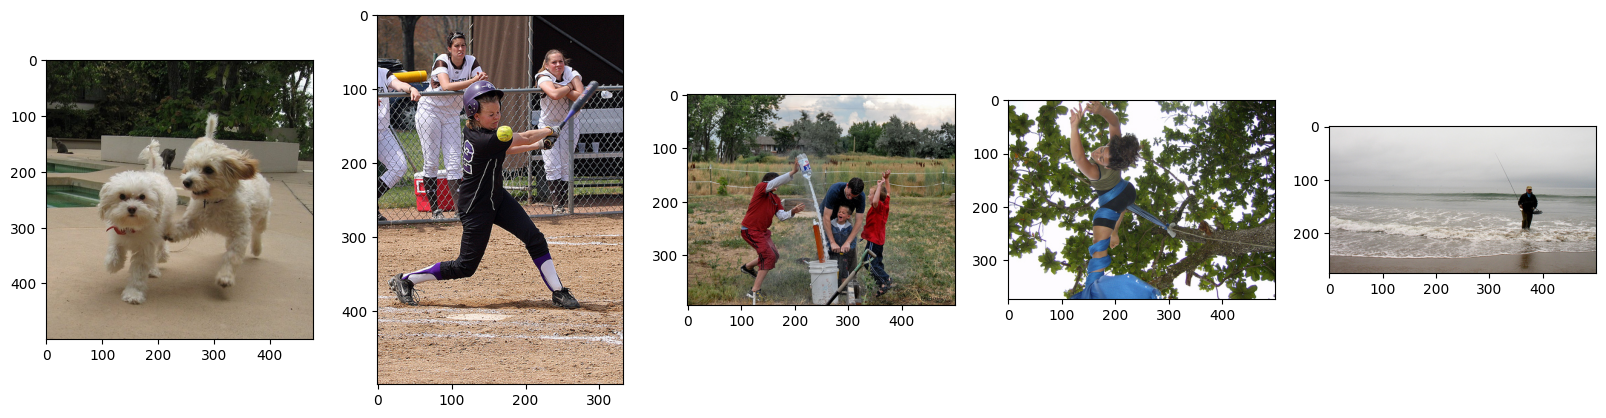

In [ ]:
#Visualise both the images & text present in the dataset

#Visualising first 5 images:

Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [ ]:
#Import the dataset and read the text file into a seperate variable

text_file = 'Flickr8K/captions.txt'

def load_doc(text_file):

    #your code here
    open_file = open(text_file, 'r', encoding="latin-1") #associate and returns a file object
    text = open_file.read()
    open_file.close()
    return text

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [ ]:
all_imgs

['Flickr8K/Images/2275029674_6d4891c20e.jpg',
 'Flickr8K/Images/3484832904_08619300d9.jpg',
 'Flickr8K/Images/2275372714_017c269742.jpg',
 'Flickr8K/Images/347186933_880caaf53b.jpg',
 'Flickr8K/Images/516725192_c9cdd63878.jpg',
 'Flickr8K/Images/3487131146_9d3aca387a.jpg',
 'Flickr8K/Images/559102835_472ff702b5.jpg',
 'Flickr8K/Images/373394550_1b2296b8c4.jpg',
 'Flickr8K/Images/2887798667_ce761d45e8.jpg',
 'Flickr8K/Images/3110649716_c17e14670e.jpg',
 'Flickr8K/Images/3477683327_d9e6a2a64f.jpg',
 'Flickr8K/Images/2866820467_ae699235a7.jpg',
 'Flickr8K/Images/3651971126_309e6a5e22.jpg',
 'Flickr8K/Images/3638178504_be1ff246bd.jpg',
 'Flickr8K/Images/190965502_0b9ed331d9.jpg',
 'Flickr8K/Images/2656987333_80dcc82c05.jpg',
 'Flickr8K/Images/661757041_61e131e913.jpg',
 'Flickr8K/Images/3546891929_f31a99cd0d.jpg',
 'Flickr8K/Images/2219805677_7b7cc188c7.jpg',
 'Flickr8K/Images/237277765_9e6fa5b99a.jpg',
 'Flickr8K/Images/334768700_51c439b9ee.jpg',
 'Flickr8K/Images/3357708906_fb3a54dd78.jp

In [ ]:
image_path='Flickr8K/Images/'
all_img_id=[]  #store all the image id here
all_img_vector=[] #store all the image path here
annotations= []#store all the captions here

with open('Flickr8K/captions.txt', 'r') as fo:
    next(fo) # to skip the heading
    for line in fo:
        split_arr=line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #striping \n and fullstop
        all_img_vector.append(image_path+split_arr[0])


df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

ID                                       Path  \
0      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  Flickr8K/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40451  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40452  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40453  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    
40454  997722733_0cb5439472.jpg   Flickr8K/Images/997722733_0cb5439472.jpg    

                                                                         Captions  
0      A child in a pink dress is climbing up a set of stairs in an entry way      
1      A girl going into a wooden building                                         
2      A little girl climbing into a wooden playhouse                              
3      A little girl climbing the stairs to her playhouse                          
4      A little girl in a pink dress going into a wooden cabin                     
...                                                         ...                    
40450  A man in a pink shirt climbs a rock face                                    
40451  A man is rock climbing high in the air                                      
40452  A person in a red shirt climbing up a rock face covered in assist handles   
40453  A rock climber in a red shirt                                               
40454  A rock climber practices on a rock climbing wall                            

[40455 rows x 3 columns]

In [ ]:
type(annotations)

list

In [ ]:
len(annotations)

40455

In [ ]:
vocabulary= [word for line in annotations for word in line.split()]
vocabulary


['A',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 'A',
 'girl',
 'going',
 'into',
 'a',
 'wooden',
 'building',
 'A',
 'little',
 'girl',
 'climbing',
 'into',
 'a',
 'wooden',
 'playhouse',
 'A',
 'little',
 'girl',
 'climbing',
 'the',
 'stairs',
 'to',
 'her',
 'playhouse',
 'A',
 'little',
 'girl',
 'in',
 'a',
 'pink',
 'dress',
 'going',
 'into',
 'a',
 'wooden',
 'cabin',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'spotted',
 'dog',
 'are',
 'fighting',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'tri-colored',
 'dog',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'the',
 'road',
 'A',
 'black',
 'dog',
 'and',
 'a',
 'white',
 'dog',
 'with',
 'brown',
 'spots',
 'are',
 'staring',
 'at',
 'each',
 'other',
 'in',
 'the',
 'street',
 'Two',
 'dogs',
 'of',
 'different',
 'breeds',
 'looking',
 'at',
 'each',
 'other',
 'on',
 'the',
 'road',
 'Two',
 'dogs',
 'on',
 'pavement',
 'moving',
 'towa

**We can see that we had both A and a are counted separately. So,let's convert all words to lower case.**

In [ ]:
#Create the vocabulary & the counter for the captions

vocabulary= [word.lower() for line in annotations for word in line.split()]

val_count=collections.Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Counts')

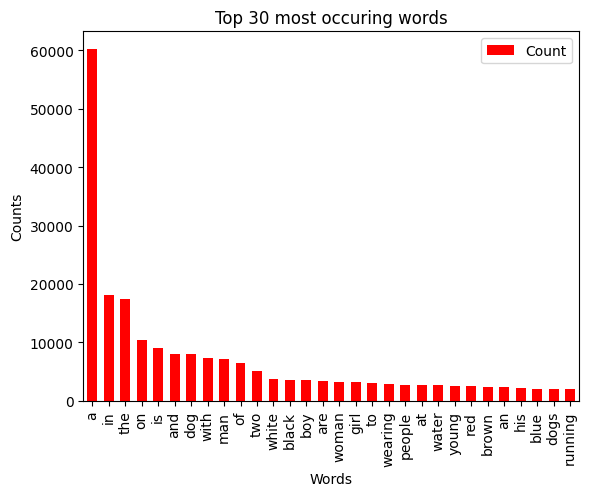

In [ ]:
#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
    print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")


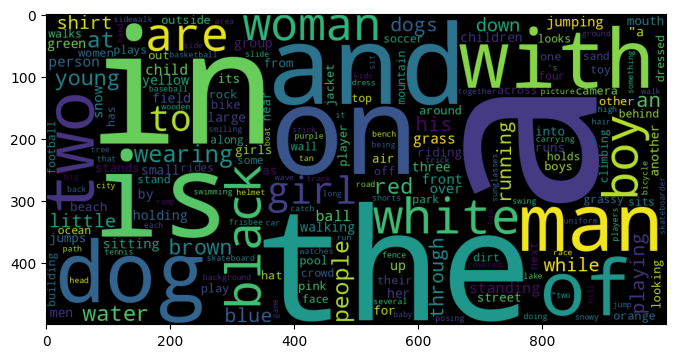

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

We can see that stopwords are having higher frequency.Let's find top 47 common words and exclude the stop words.

{'dog': 7948, 'man': 7137, 'two': 5132, 'white': 3706, 'black': 3620, 'boy': 3514, 'woman': 3304, 'girl': 3277, 'wearing': 2916, 'people': 2811, 'water': 2676, 'young': 2587, 'red': 2553, 'brown': 2457, 'blue': 2125, 'dogs': 2095, 'running': 1996, 'playing': 1954, 'little': 1736, 'shirt': 1735, 'standing': 1702, 'ball': 1678, 'grass': 1565, 'person': 1515, 'child': 1507, 'snow': 1439, 'jumping': 1430, 'front': 1322, 'sitting': 1322, 'small': 1257}


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 [Text(0, 0, 'dog'),
  Text(1, 0, 'man'),
  Text(2, 0, 'two'),
  Text(3, 0, 'white'),
  Text(4, 0, 'black'),
  Text(5, 0, 'boy'),
  Text(6, 0, 'woman'),
  Text(7, 0, 'girl'),
  Text(8, 0, 'wearing'),
  Text(9, 0, 'people'),
  Text(10, 0, 'water'),
  Text(11, 0, 'young'),
  Text(12, 0, 'red'),
  Text(13, 0, 'brown'),
  Text(14, 0, 'blue'),
  Text(15, 0, 'dogs'),
  Text(16, 0, 'running'),
  Text(17, 0, 'playing'),
  Text(18, 0, 'little'),
  Text(19, 0, 'shirt'),
  Text(20, 0, 'standing'),
  Text(21, 0, 'ball'),
  Text(22, 0, 'grass'),
  Text(23, 0, 'person'),
  Text(24, 0, 'child'),
  Text(25, 0, 'snow'),
  Text(26, 0, 'jumping'),
  Text(27, 0, 'front'),
  Text(28, 0, 'sitting'),
  Text(29, 0, 'small')])

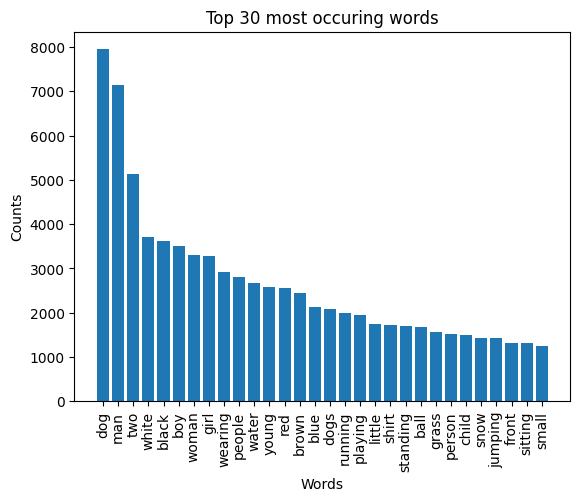

In [ ]:
dict_without_stopwords = {}
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count
print(dict_without_stopwords)

#plt.bar(*zip(*dict_without_stopwords.items()))
#plt.show()
plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align='center')
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()))
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.xticks(rotation=90)



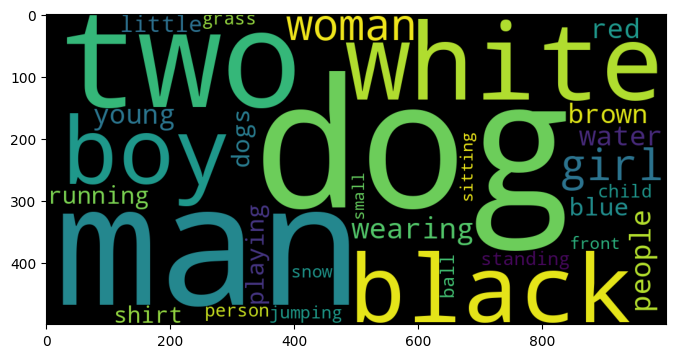

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

### Until now we visualized the images and captions separately.Now let's visualize both of them together.


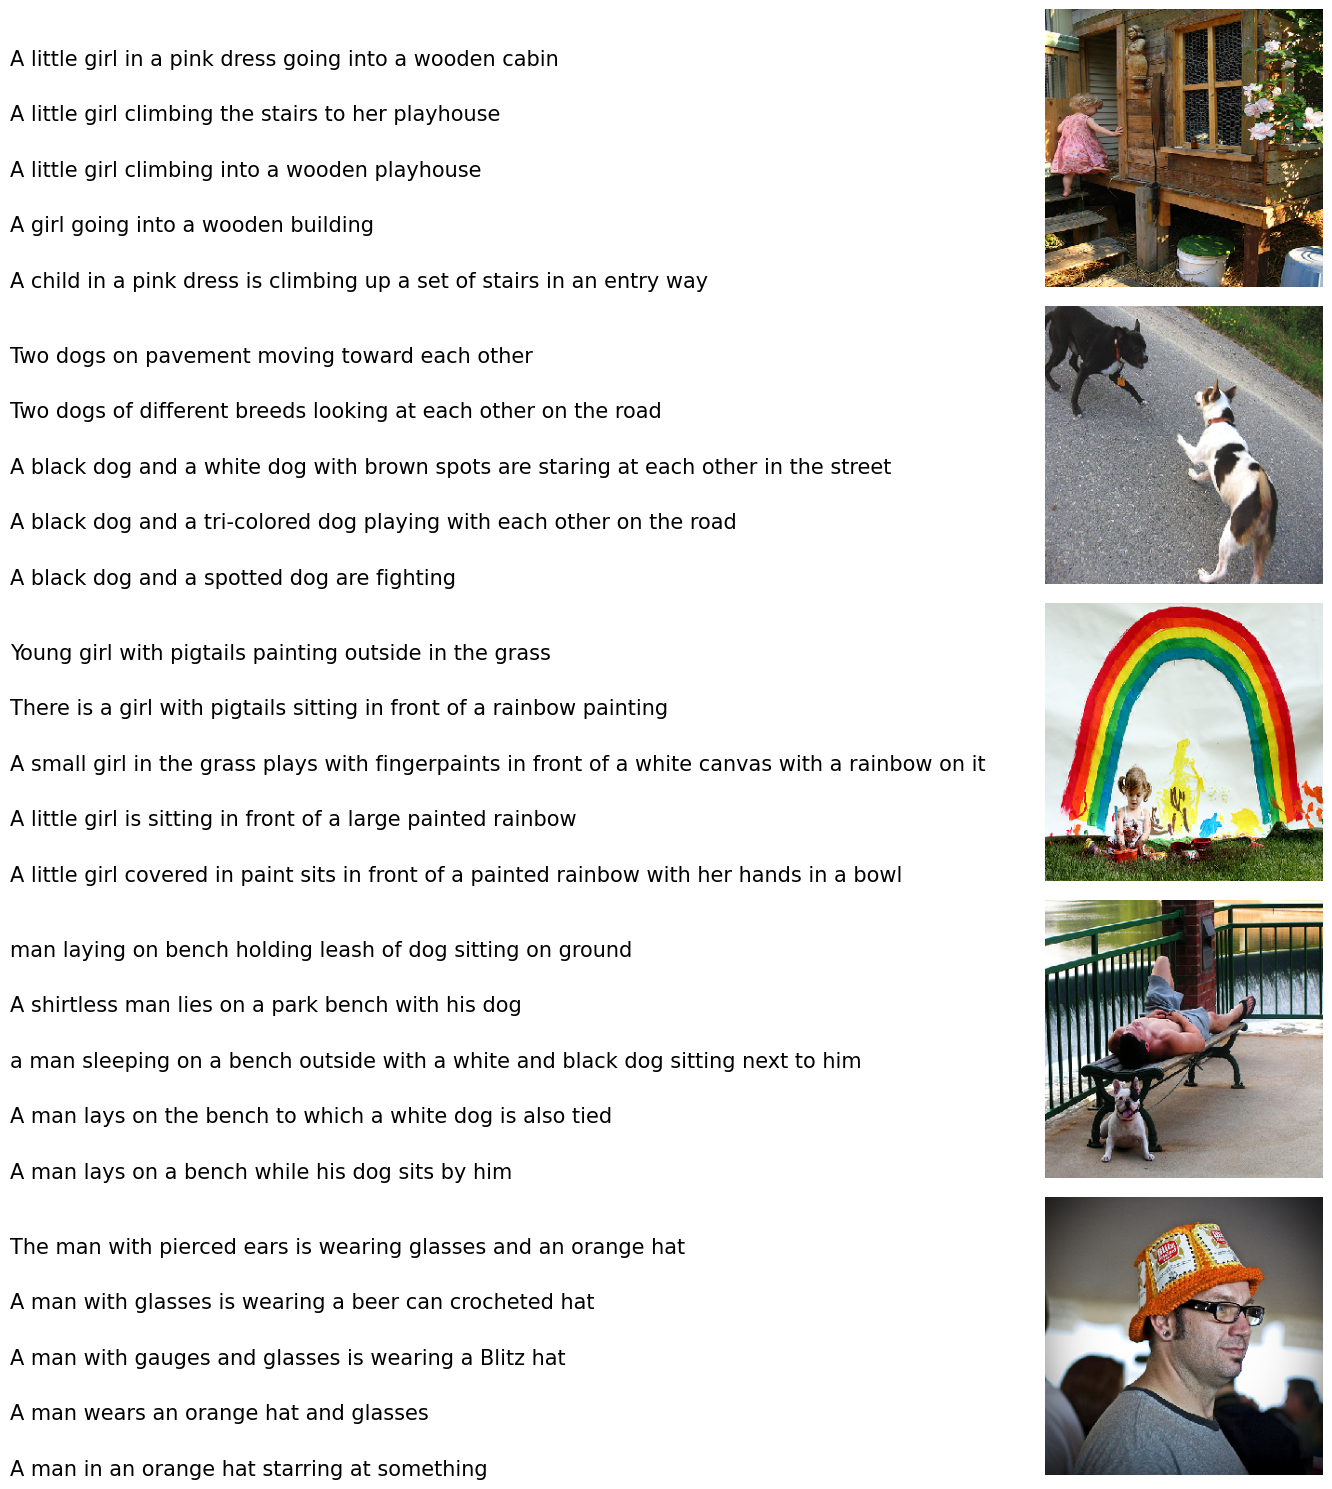

In [ ]:
# Images

fig = plt.figure(figsize=(15,15)) # For displaying image
count = 1

for Path in df[:25].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)  #display the captions
    count+=1
    plt.tight_layout()

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()



### Data Cleaning

- Converting all words to lower case
- Removing punctuations
- Retaining only words by removing numbers
- We are not removing stopwords but removing hanging s ,a or any one letter word.
- We are not performing stemming.

In [ ]:
# Data cleaning
# prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line] # remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()] # remove tokens with numbers in them
    annotations[i]=  ' '.join(line)  # store as string

In [ ]:
#Create a list which contains all the captions

#add the <start> & <end> token to all those captions as well
annotations=['<start>' + ' ' +  line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path= all_img_vector

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [ ]:
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters.
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

### Create the tokenizer

- We have already removed numeric character in previous step.
- Let's remove punctuations using filter again for to be sure(The default is all punctuation, plus tabs and line breaks, minus the ' character.)

- Convert words to lower case (this is also already done.Let's do again to be safe)
- And,replace out-of-vocabulary words with UNK token and assign PAD token for reseved zero index

In [ ]:

top_voc = 5000
tokenizer =Tokenizer(num_words=top_voc+1,filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ',
                                                  lower=True, char_level=False,
                                                  oov_token="<unk>")


# Create word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations) #Updates internal vocabulary based on a list of texts.

train_seqs = tokenizer.texts_to_sequences(annotations)#Transforms each text in texts to a sequence of integers.

# when we use the pad_sequence to process the sequence, we will be using 0 as the padding value.
# In order to distinguish between PAD and UNKNOWN, keras use different index for UNKNOWN.

# 0 is a reserved index that won't be assigned to any word.Let's add PAD token for zero

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'


In [ ]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])


<unk>
<pad>


In [ ]:
tokenizer.index_word


{1: '<unk>',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: '

In [ ]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('child', 1517),
             ('in', 18182),
             ('pink', 702),
             ('dress', 332),
             ('is', 9069),
             ('climbing', 490),
             ('up', 1215),
             ('set', 105),
             ('of', 6496),
             ('stairs', 109),
             ('an', 2358),
             ('entry', 1),
             ('way', 48),
             ('<end>', 40455),
             ('girl', 3284),
             ('going', 145),
             ('into', 1046),
             ('wooden', 278),
             ('building', 485),
             ('little', 1750),
             ('playhouse', 6),
             ('the', 17676),
             ('to', 3005),
             ('her', 1102),
             ('cabin', 4),
             ('black', 3627),
             ('dog', 7956),
             ('and', 8057),
             ('spotted', 36),
             ('are', 3365),
             ('fighting', 130),
             ('tricolored', 12),
             ('playing', 1954),
        

In [ ]:
annotations[:5]


['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [ ]:
train_seqs[:5]

[[2, 43, 4, 88, 169, 7, 115, 52, 390, 12, 382, 4, 28, 1, 687, 3],
 [2, 19, 309, 63, 193, 119, 3],
 [2, 37, 19, 115, 63, 193, 2354, 3],
 [2, 37, 19, 115, 5, 382, 20, 62, 2354, 3],
 [2, 37, 19, 4, 88, 169, 309, 63, 193, 2889, 3]]

In [ ]:
print(len(train_seqs))
print(type(train_seqs))

40455
<class 'list'>


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


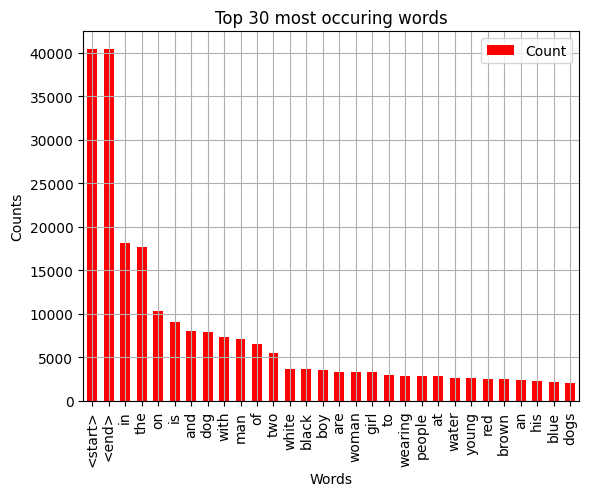

In [ ]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

#your code here
tokenizer_top_words= [word for line in annotations for word in line.split()]

tokenizer_top_words_count=collections.Counter(tokenizer_top_words)
tokenizer_top_words_count

for word, count in tokenizer_top_words_count.most_common(30):
    print(word, ": ", count)

token_lst = tokenizer_top_words_count.most_common(30)
most_common_words_df = pd.DataFrame(token_lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word',y='Count',width=0.6,color='red')
plt.title("Top 30 most occuring words")
plt.xlabel("Words")
plt.ylabel("Counts")
plt.grid()

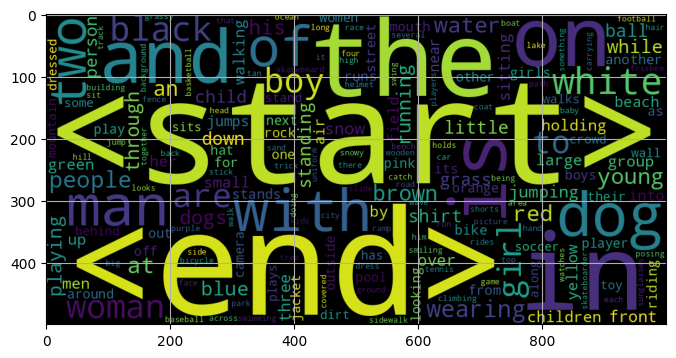

In [ ]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_token)
plt.grid()

In [ ]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_seqs_len=[len(seq) for seq in train_seqs] #storing all lengths in list.Can be used if needed in future
longest_word_length= max(train_seqs_len) #Python list method max returns the elements from the list with maximum value.

# Calculates the longest_word_length to pad all sequences to be the same length as the longest one.

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=longest_word_length,
                                                          dtype='int32', value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))


The shape of Caption vector is :(40455, 31)


We are padding zero at last using padding='post'. We know that start token acts as prompter and it expect some word after tat.
Zero indicates no word and have no value at beginning.So,in order to not disturb the
existing sequence structure we pad at end. This padding will cause problem while creating embedding vector.So we will be applying mask then.

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3.

In [ ]:
#checking to know about image format as we will be setting data format as none in tf.keras.applications.inception_v3.preprocess_input

tf.keras.backend.image_data_format()

'channels_last'

Image data format have default as 'channels_last' which indicates Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].

In [ ]:
IMAGE_SHAPE= (299, 299)

In [ ]:
#write your code here
#Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img=[]
for img in all_imgs[0:5]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=3) #Since its RGB images,we can give channels=3, which will output an RGB image.
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


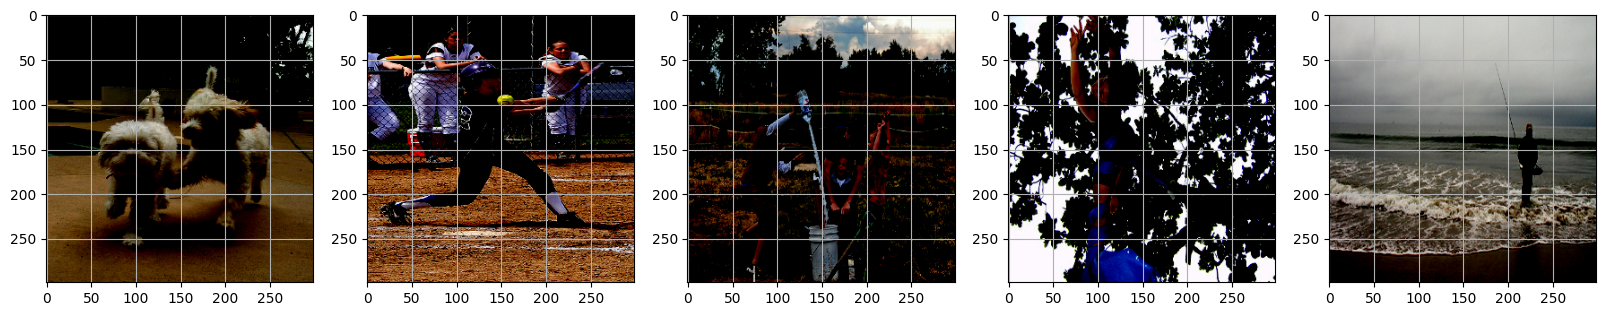

In [ ]:
Display_Images= preprocessed_img[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)

for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.grid('off')
    ax.imshow(image)

Let's write a function for preprocessing and return images and it's path so that we can
use concept of ***vectorization and preprocess images paralleley rather than writing for loop***.

In [ ]:
#write your code here

def preprocess_images_function(image_path):

    img = tf.io.read_file(image_path,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE)
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None) #Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    return img, image_path

## Create the train & test data
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [ ]:
all_img_vector

['Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1000268201_693b08cb0e.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1001773457_577c3a7d70.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1002674143_1b742ab4b8.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1003163366_44323f5815.jpg',
 'Flickr8K/Images/1007129816_e794419615.jpg',
 'Flickr8K/Images/1007129816_e7944

In [ ]:
#write your code here
# mapping each image full path including name to the function to preprocess the image

# sorting and storing unique path in list which will be given as input
training_list = sorted(set(all_img_vector))

# Creating a Dataset using tf.data.Dataset.from_tensor_slice
New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# Mappng preprocess_images_function across the elements of the above dataset.
# num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
New_Image_Data = New_Image_Data.map(preprocess_images_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False
New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [ ]:
New_Image_Data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
#write your code here

# performing the train-test spliit using 80-20 ratio & random state = 42

img_train_data, img_test_data, caption_train_data, caption_test_data = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [ ]:
print("No of images in training dataset: ",len(img_train_data))
img_train_data[0:5]


No of images in training dataset:  32364


['Flickr8K/Images/359082432_c1fd5aa2d6.jpg',
 'Flickr8K/Images/2460799229_ce45a1d940.jpg',
 'Flickr8K/Images/3634828052_3b6aeda7d6.jpg',
 'Flickr8K/Images/2216568822_84c295c3b0.jpg',
 'Flickr8K/Images/3080056515_3013830309.jpg']

In [ ]:
print("No of images in testing dataset: ",len(img_test_data))
img_test_data[0:5]

No of images in testing dataset:  8091


['Flickr8K/Images/2973269132_252bfd0160.jpg',
 'Flickr8K/Images/270263570_3160f360d3.jpg',
 'Flickr8K/Images/2053006423_6adf69ca67.jpg',
 'Flickr8K/Images/512101751_05a6d93e19.jpg',
 'Flickr8K/Images/3156406419_38fbd52007.jpg']

In [ ]:
print("No of captions in training dataset: ",len(caption_train_data))
caption_train_data[0:5]

No of captions in training dataset:  32364


array([[   2,   11,    8,    9,   17,   39,    6,  146,  148,  110,  542,
          46,   20,    5,  170,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,    5,   47,   95,  238,   17,   21,  472,  543,   17,   90,
          63,    5,   24,    3,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   94,   10,  283,  195, 2640,  278,  140,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   18,   10,   26, 2236,  168,    8, 1869,  455, 1056,    6,
          62,  325,    3,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   80,   42,    7, 3255,   20,   72,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

In [ ]:
print("No of captions in testing dataset: ",len(caption_test_data))
caption_test_data[0:5]

No of captions in testing dataset:  8091


array([[   2,   54, 1626,  588,    7, 4556,  223,  121, 1476,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   13,   27,   31,  500,    6,    5, 1681,  170,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   11,    4,  164,    7,   39,    6,   82,   90,   87,   23,
           5,  458,   74,    5, 3975,    3,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,  887,   14,    9,    7,   32,    6,    5,   41,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   42,  376,  727,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the image using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048.

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



**Inception v3 is a widely-used image recognition model that has been shown to attain greater than 78.1% accuracy on the ImageNet dataset. So let's also use same model to get feature vector.**


In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output #write code here to get the output of the image_model

#image_features_extract_model = keras.Model(new_input, hidden_layer) #build the final model using both input & output layer
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

We are not classifying the images here. Rather,we only need to extract an image vector for our images.Hence we are removing the softmax layer from the model.

In [ ]:
# write your code to extract features from each image in the dataset
image_features_dict={}
for image, image_path in tqdm(New_Image_Data): #using tqdm as progress bar
    features_for_batch = image_features_extract_model(image) #feeding images from above created dataset to Inception v3 which we build above
    #fb_shape = features_for_batch.get_shape().as_list()
    #features_for_batch_flattened = tf.contrib.layers.flatten(fb_shape)
    features_for_batch_flattened = tf.reshape(features_for_batch,
                             (features_for_batch.shape[0], -1, features_for_batch.shape[3])) ##We are sqeezing/squashing

    for batch_feat, path in zip(features_for_batch_flattened, image_path):
        feature_path = path.numpy().decode("utf-8")
        image_features_dict[feature_path] =  batch_feat.numpy()



100%|██████████| 127/127 [03:06<00:00,  1.46s/it]


In [ ]:
features_for_batch

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
          2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          9.4265595e-02, 0.0000000e+00, 5.0578970e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

        [[0.0000000e+00, 4.2300537e-01, 1.3446197e-02, ...,
          2.3367137e-01, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          4.9979120e-02, 0.0000000e+00, 0.0000000e+00]

In [ ]:
features_for_batch_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7467650e-02, 0.0000000e+00, ...,
         2.3183759e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0778813e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9403169e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8575513e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569363e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0261021e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1791839e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347540e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506025e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8497171e-02, ...,
         1.2064208e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [ ]:
len(image_features_dict)

8091

In [ ]:
batch_feat.shape

TensorShape([64, 2048])

In [ ]:
import more_itertools
top_5_items = more_itertools.take(5, image_features_dict.items())

top_5_items #printing first 5 elememts have dictionary

[('Flickr8K/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.1698712 ],
         [0.        , 0.        , 1.0105925 , ..., 0.        , 0.        ,
          0.06111747],
         ...,
         [0.        , 0.        , 2.038041  , ..., 1.2029699 , 0.        ,
          1.992411  ],
         [0.        , 0.        , 0.9046886 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527242 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('Flickr8K/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.66367984, 0.46286014, ..., 0.        , 0.        ,
          3.3322585 ],
         [0.        , 1.2268146 , 0.        , ..., 0.        , 0.25390285,
          3.3295312 ],
         [1.2881926 , 1.5195405 , 0.        , ..., 0.46777815, 0.3647463 ,
          3.817

In [ ]:
#we need to give both images and caption to model as input
def model_input(image,captions):
    image_final = image_features_dict[image.decode('utf-8')]
    return image_final,captions

In [ ]:
# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 1000

# Batch size
BATCH_SIZE = 64 ##tried with different batch sizes.kernal is dieing for 32 .So finally fixed 64.

def data_generator(images_data, captions_data):

    # Creating a Dataset using tf.data.Dataset.from_tensor_slice
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))

    # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(model_input, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # reshuffle_each_iteration=True indicate Shuffle order should be different for each epoch.
    # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
    # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False
    # Prefetch function is used to prepare later elements while the current element is being processed.

    dataset = (
     dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    .batch(BATCH_SIZE, drop_remainder=False)
    .prefetch(tf.data.experimental.AUTOTUNE)
    )

    return dataset

In [ ]:
train_dataset=data_generator(img_train_data,caption_train_data)
test_dataset=data_generator(img_test_data,caption_test_data)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(64, 64, 2048)
(64, 31)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [ ]:
embedding_dim = 256
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(img_train_data) // BATCH_SIZE  #len(total train images) // BATCH_SIZE
test_num_steps = len(img_test_data) // BATCH_SIZE   #len(total test images) // BATCH_SIZE
max_length=31
features_shape = batch_feat.shape[1]
attention_features_shape = batch_feat.shape[0]

### Encoder

In [ ]:
tf.compat.v1.reset_default_graph() #to resolve compatibility issue
#from tensorflow.python.framework import ops
#ops.reset_default_graph()
#tf.compat.v1.GraphDef()

In [ ]:
print(tf.compat.v1.get_default_graph())


In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        #It acts as the fully connected layer
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self, features):
        features = self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        #features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0) #applying relu activation
        features = tf.nn.relu(features)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 =  tf.keras.layers.Dense(units)#build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1)#build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        # hidden_with_time_axis=hidden[:, tf.newaxis] # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis =  tf.expand_dims(hidden, 1)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))# build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights =  tf.keras.activations.softmax(self.V(score), axis=1)# extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector =  attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)# reduce the shape to (batch_size, embedding_dim)
        # the tensor is reduced along the second dimension (columns)

        return context_vector, attention_weights



The attention model does a linear transformation of the input.So we are applying tanh function on top of it.The features produced from dense layer(FC layer) of encoder and hidden state of decoder are passed to tanh function and attention score is calculated

In other words, the tanh function is introduced to do non linear transformation and give smooth output .Since we need output in range (0,1), we apply softmax function on the obtained attention score which now gives the atttention weights.

Finally we computed a weighted sum of the attention weights on the feature vector and thus, derived our context vector.

This context vector produced are adaptive as they change for each and every time stamp.

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units)#iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)#build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)   #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden)#create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x))
        mask = self.embed.compute_mask(x)
        #embed = self.embed(x)# embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)# Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed, mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output,state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


We know that the encoder output along with hidden state is passed to attention model.The attention model produces context vector.This context vector is concatenated with embedded vector formed from embedding layer and passed to GRU.After passing
the GRU output to dense layers,finally we are trying to obtain output in shape of vocab_size as we need to assign probabilities for each and every word in vocabulary.

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer =tf.keras.optimizers.Adam(lr=0.001) #define the optimizer
loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction=tf.keras.losses.Reduction.NONE) #define your loss object
#we always need to choose appropriate loss function.Let us use crossentropy SparseCategoricalCrossentropy.
# It calculates loss between the labels and predictions.

In [ ]:
# zero is causing discrepency.we dont want decoder to give importance to zero.so lets mask zero to false

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # we are multiplying loss with mask to get ideal shape

    return tf.reduce_mean(loss_)

In [ ]:
#path='https://upgrad.nimblebox.ai/project/upg-aruna-4881-21712/tree?/checkpoint'
#os.mkdir(path)

checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: #Record operations for automatic differentiation for implementing backpropagation
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          dec_input = tf.expand_dims(target[:, t], 1)

    avg_loss = (loss / int(target.shape[1])) #we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))

    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    #hidden = decoder.reset_state(batch_size=target.shape[0]) #we dont have reset_state method
    hidden = decoder.init_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: #Record operations for automatic differentiation.
        #write your code here to do the training steps
        encoder_output = encoder(img_tensor)

        # Using the teacher forcing technique where the target word is passed as the next input to the decoder.
        for t in range(1, target.shape[1]):
          # passing encoder_output to the decoder
          predictions, hidden, _ = decoder(dec_input, encoder_output, hidden)

          loss += loss_function(target[:, t], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, t], 1)

    avg_loss = (loss / int(target.shape[1]))#we are calculating average loss for every batch

    tot_trainables_variables = encoder.trainable_variables + decoder.trainable_variables

    grads = tape.gradient(loss, tot_trainables_variables) # to calculate gradients with respect to every trainable variable

    #compute gradients and apply it to the optimizer and backpropagate.
    optimizer.apply_gradients(zip(grads, tot_trainables_variables))

    return loss, avg_loss

We are using teacher forcing as training converges faster. Also, in the initial steps of training, the predictions of the model are very bad. If we are not using it, the hidden states of the model might be updated with the sequence of wrong predictions because of the relational understading present between words, and this mislead the model as errors will keep on adding, and the model will learn wrongly and perform badly at the end.So in order to train the model in right direction, we are doing this tweaking and forcing the model to predict correctly by passing the target word as the next input to the decoder

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps

    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)

    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/10 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.439, & test loss is 1.212
Time taken for 1 epoch 472.84116315841675 sec

Test loss has been reduced from 100.000 to 1.212


 20%|██        | 2/10 [13:48<53:49, 403.70s/it]  

For epoch: 2, the train loss is 1.118, & test loss is 1.063
Time taken for 1 epoch 355.0120086669922 sec

Test loss has been reduced from 1.212 to 1.063


 30%|███       | 3/10 [19:34<44:02, 377.45s/it]

For epoch: 3, the train loss is 1.011, & test loss is 0.974
Time taken for 1 epoch 346.05659341812134 sec

Test loss has been reduced from 1.063 to 0.974


 40%|████      | 4/10 [25:04<35:53, 358.87s/it]

For epoch: 4, the train loss is 0.937, & test loss is 0.909
Time taken for 1 epoch 330.21423625946045 sec

Test loss has been reduced from 0.974 to 0.909


 50%|█████     | 5/10 [30:54<29:38, 355.60s/it]

For epoch: 5, the train loss is 0.878, & test loss is 0.856
Time taken for 1 epoch 349.65189933776855 sec

Test loss has been reduced from 0.909 to 0.856


 60%|██████    | 6/10 [36:11<22:49, 342.36s/it]

For epoch: 6, the train loss is 0.827, & test loss is 0.807
Time taken for 1 epoch 316.51117634773254 sec

Test loss has been reduced from 0.856 to 0.807


 70%|███████   | 7/10 [41:19<16:33, 331.11s/it]

For epoch: 7, the train loss is 0.782, & test loss is 0.764
Time taken for 1 epoch 307.8065254688263 sec

Test loss has been reduced from 0.807 to 0.764


 80%|████████  | 8/10 [46:28<10:48, 324.20s/it]

For epoch: 8, the train loss is 0.740, & test loss is 0.725
Time taken for 1 epoch 309.26163840293884 sec

Test loss has been reduced from 0.764 to 0.725


 90%|█████████ | 9/10 [51:22<05:14, 314.74s/it]

For epoch: 9, the train loss is 0.702, & test loss is 0.687
Time taken for 1 epoch 293.76867151260376 sec

Test loss has been reduced from 0.725 to 0.687


100%|██████████| 10/10 [56:22<00:00, 338.29s/it]

For epoch: 10, the train loss is 0.669, & test loss is 0.657
Time taken for 1 epoch 300.1748604774475 sec

Test loss has been reduced from 0.687 to 0.657


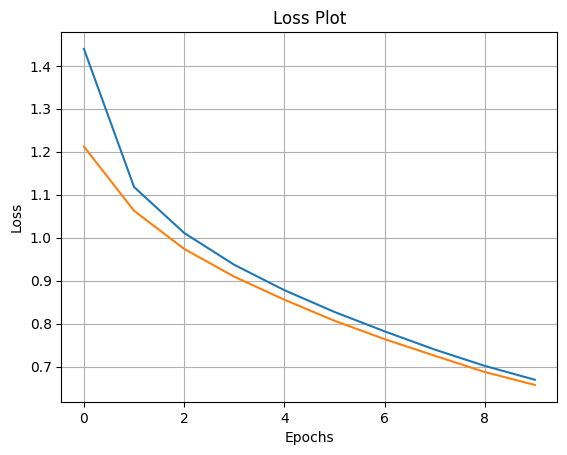

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.grid('off')
plt.show()


## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_images_function(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id =  tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))

    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))

        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)

        img=ax.imshow(temp_img)

        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
img_test=img_test_data.copy()

In [ ]:
#modifying the given code as function to run it several times by changing weights
def predicted_caption_audio(random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test=caption_test_data.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights) #set your weights
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Let's use Google Text to Speech Online API from playing the predicted caption as audio
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))

    return test_image

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 44.721359549995796
Real Caption: person skiing downhill
Prediction Caption: person skiing down snowy mountain


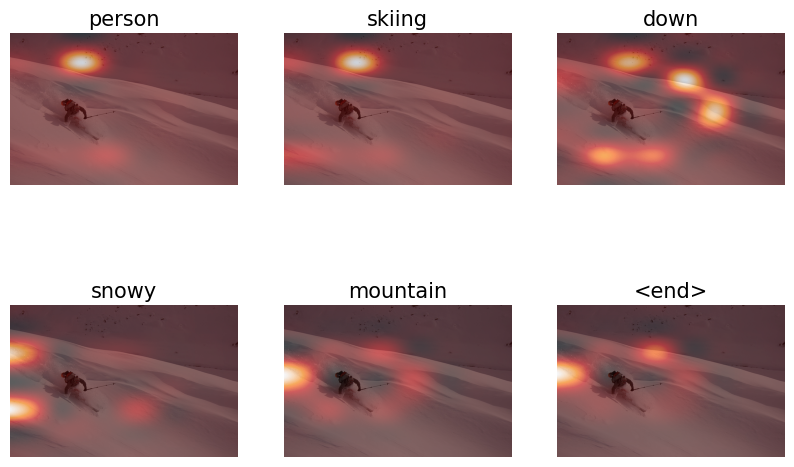

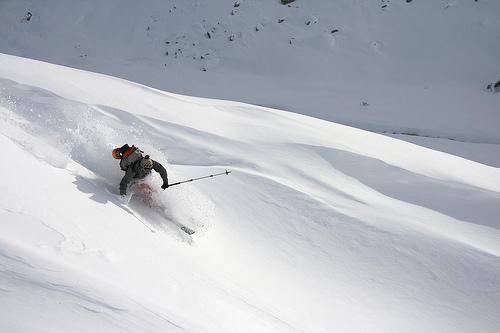

In [ ]:
test_image=predicted_caption_audio(5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

BELU score: 63.56579408934371
Real Caption: group of people watching large explosion
Prediction Caption: group of people watching helicopter fly fire


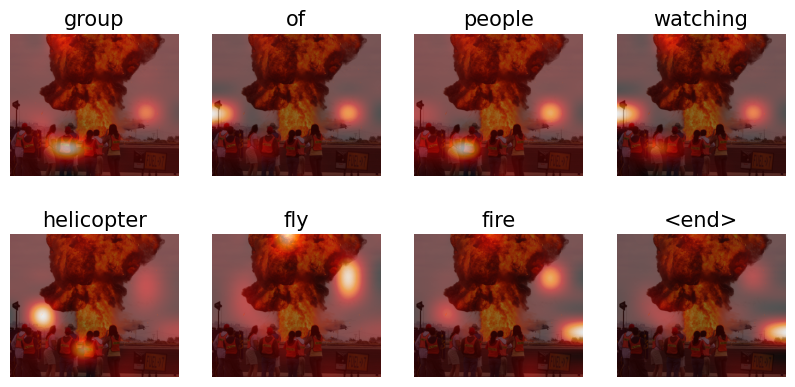

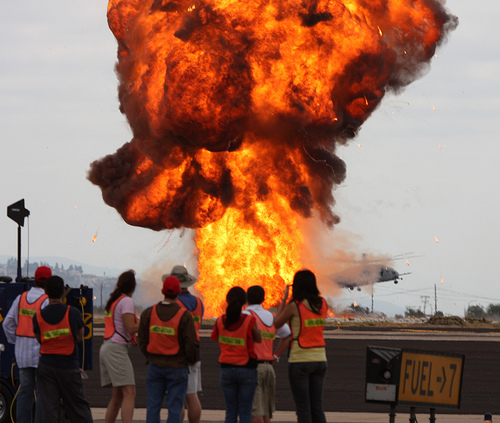

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 55.55238068023583
Real Caption: white gull flying over ocean
Prediction Caption: white pelican is flying over the ocean


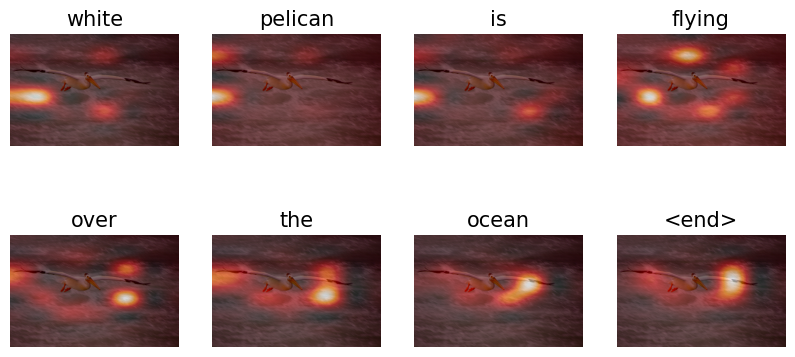

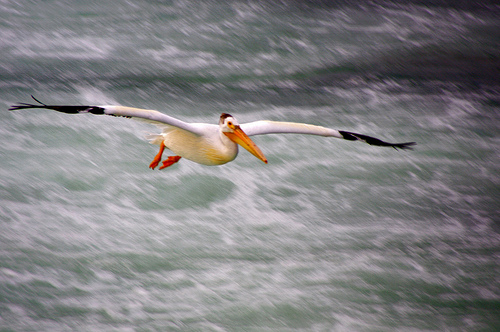

In [ ]:
test_image1=predicted_caption_audio(len(img_test),False,weights=(0.25,0.25,0,0))

Image.open(test_image1)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 49.74292207467277
Real Caption: many brides line up on the street
Prediction Caption: group of brides line up in line


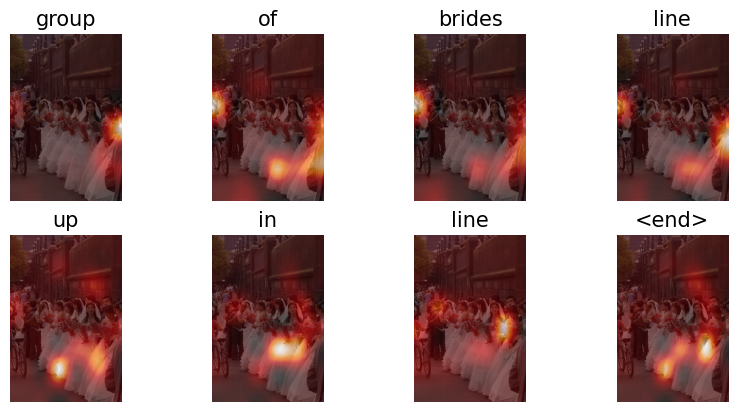

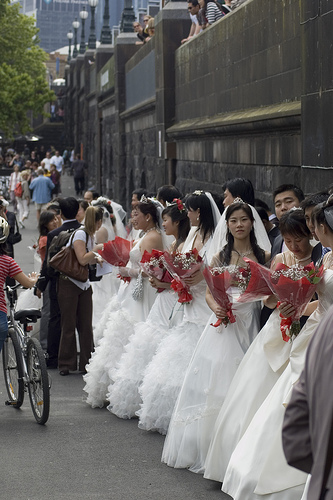

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.25,0,0))

Image.open(test_image)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 16.23567485864776
Real Caption: bunch of kids are climbing on tree and it up
Prediction Caption: children are playing on tree tree


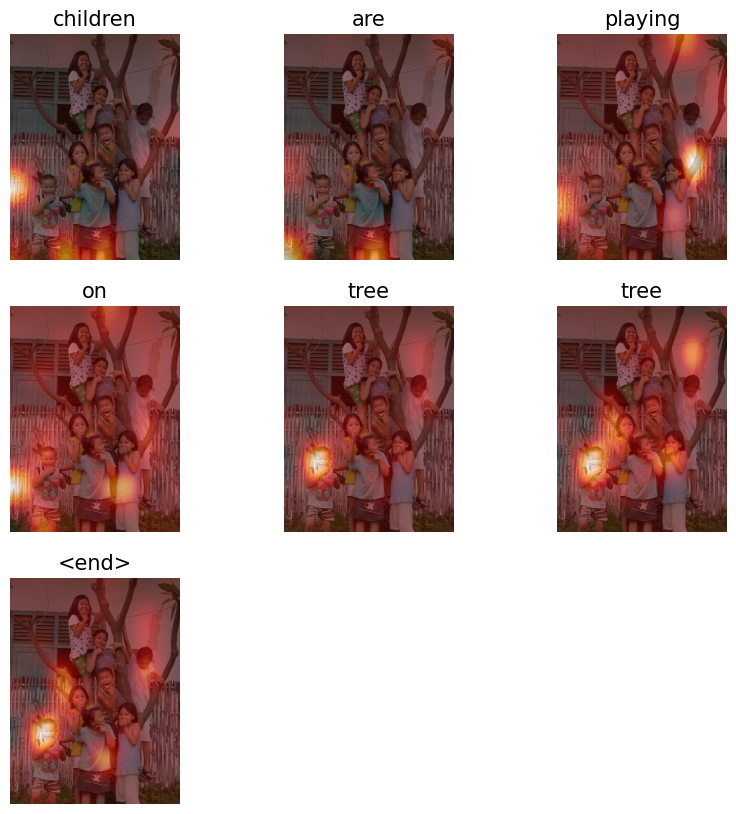

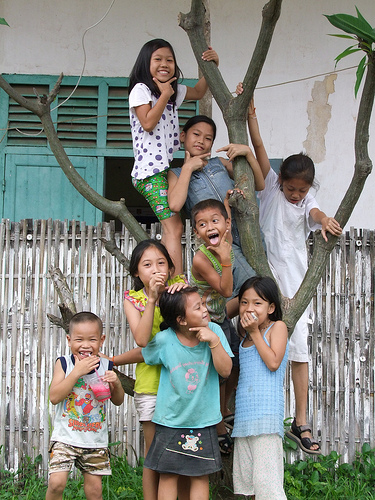

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BELU score: 3.284583616709323e-153
Real Caption: girl begins to wade through deep grass that covers stone structure on coastline
Prediction Caption: girl is walking through the grass


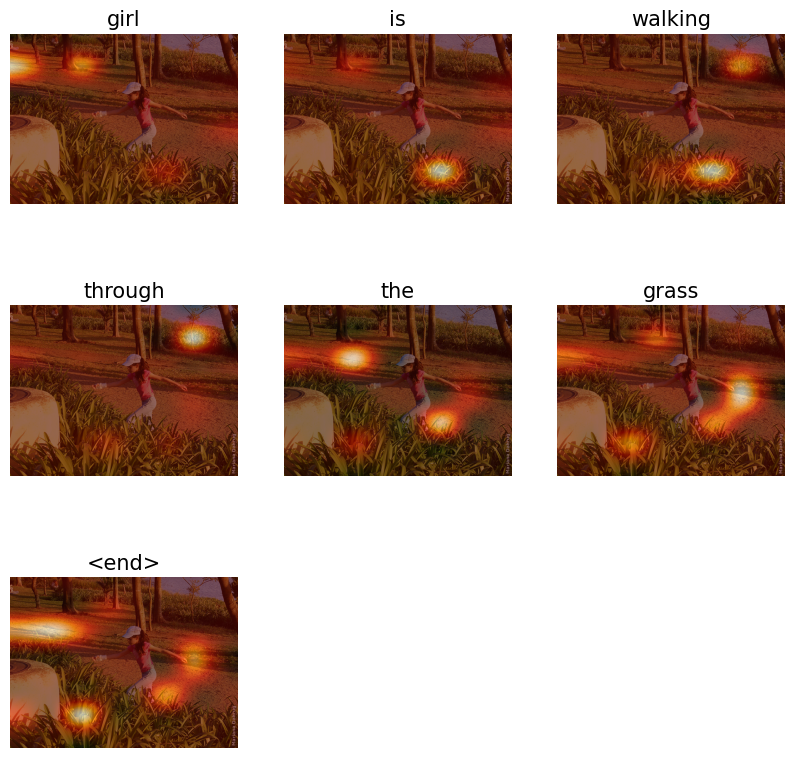

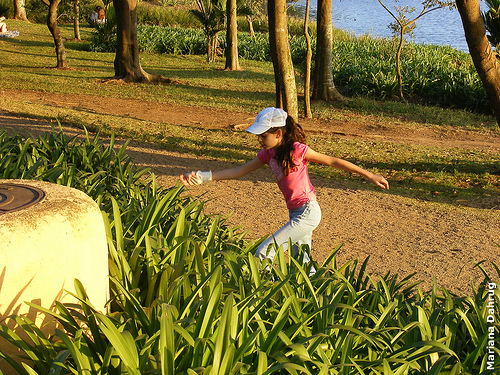

In [ ]:
test_image=predicted_caption_audio(len(img_test),False,weights=(0.5,0.5,0,0))

Image.open(test_image)